# Operational margin (Online Methods)

This notebook reproduces the **supporting analyses** for the operational margin
$\Delta_{\mathrm{op}}$, including:

1. One-dimensional sweeps versus $I_{\max}$ at selected $\chi$.
2. **Network stability analysis** using linearization around equilibria.
3. Topology comparison (chain, star, scale-free) via spectral properties.

**Key distinction**: $\Delta_{\mathrm{op}}$ assesses **equilibrium existence** for isolated nodes.
Network stability requires **additional analysis** via the Jacobian eigenvalues.

**NOTE**: This notebook imports NOS modules from src/. See the repository README section “Running notebooks” for setup.


In [ ]:
from __future__ import annotations

import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

REPO_ROOT = Path("..").resolve()
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

try:
    from nos import NOSParams
    from topology import TopologySpec, build_topology, spectral_radius
    from linearisation import (
        LinPoint,
        surrogate_block_jacobian_no_delay,
        surrogate_leading_real_part_eig,
        surrogate_find_k_star_bisect_no_delay,
        surrogate_predict_k_star_hopf_mode,
    )
except Exception:
    from src.nos import NOSParams
    from src.topology import TopologySpec, build_topology, spectral_radius
    from src.linearisation import (
        LinPoint,
        surrogate_block_jacobian_no_delay,
        surrogate_leading_real_part_eig,
        surrogate_find_k_star_bisect_no_delay,
        surrogate_predict_k_star_hopf_mode,
    )

OUT_DIR = REPO_ROOT / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)


## Parameters

Match the main figure notebook (`01_op_margin_main.ipynb`).

In [ ]:
p = NOSParams(
    alpha=0.10,
    kappa=0.0,
    beta=0.80,
    gamma=0.02,
    lam=0.40,
    chi=0.0,
    v_rest=0.0,
    a=1.0,
    b=1.0,
    mu=0.20,
)

alpha = p.alpha
beta = p.beta
lam = p.lam
a, b, mu = p.a, p.b, p.mu
gamma = p.gamma
v_rest = p.v_rest

chi_max = 0.50
Imax_max = 0.60


In [ ]:
def L_of_chi(chi: np.ndarray) -> np.ndarray:
    """Effective linear coefficient (includes recovery contribution)."""
    return (beta - lam - chi) - (a * b) / (a + mu)

def C_of_chi(chi: np.ndarray) -> np.ndarray:
    """Constant term in equilibrium equation."""
    return gamma + chi * v_rest

def delta_op(chi: np.ndarray, Imax: np.ndarray) -> np.ndarray:
    """Operational margin: Δ_op > 0 ⟹ equilibrium exists for I ≤ I_max."""
    L = L_of_chi(chi)
    C = C_of_chi(chi)
    return (L * L) / (4.0 * alpha) - (C + Imax)

def Imax_star(chi: np.ndarray) -> np.ndarray:
    """Boundary I_max*(χ) where Δ_op = 0."""
    L = L_of_chi(chi)
    C = C_of_chi(chi)
    return (L * L) / (4.0 * alpha) - C


## 1) 1D Sweeps: $\Delta_{\mathrm{op}}$ versus $I_{\max}$}

Plot $\Delta_{\mathrm{op}}$ as a function of $I_{\max}$ for selected values of $\chi$, marking the crossing $I_{\max}^*$ where $\Delta_{\mathrm{op}} = 0$.


✓ Saved: fig_op_margin_sweeps_Imax.png


PosixPath('/outputs/fig_op_margin_sweeps_Imax.png')

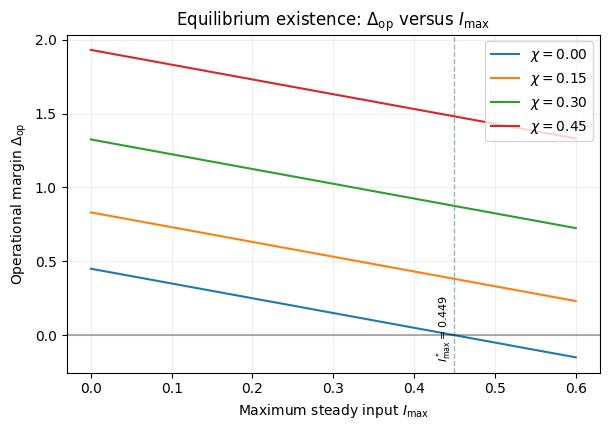

In [ ]:
I = np.linspace(0.0, Imax_max, 600)
chis = np.array([0.0, 0.15, 0.30, 0.45])

fig, ax = plt.subplots(figsize=(6.2, 4.4))

for chi in chis:
    D = delta_op(chi*np.ones_like(I), I)
    ax.plot(I, D, label=fr"$\chi={chi:.2f}$")

    Istar = float(Imax_star(np.array([chi]))[0])
    if 0.0 <= Istar <= Imax_max:
        ax.axvline(Istar, linewidth=1.0, linestyle="--", alpha=0.5)
        ax.text(Istar, ax.get_ylim()[0], fr"$I^*_{{\max}}={Istar:.3f}$",
                rotation=90, va="bottom", ha="right", fontsize=8)

ax.axhline(0.0, color='k', linewidth=1.5, linestyle='-', alpha=0.3)
ax.set_xlabel(r"Maximum steady input $I_{\max}$")
ax.set_ylabel(r"Operational margin $\Delta_{\mathrm{op}}$")
ax.set_title(r"Equilibrium existence: $\Delta_{\mathrm{op}}$ versus $I_{\max}$")
ax.legend(frameon=True, loc='best')
ax.grid(alpha=0.2)

fig.tight_layout()
png_path = OUT_DIR / "fig_op_margin_sweeps_Imax.png"
pdf_path = OUT_DIR / "fig_op_margin_sweeps_Imax.pdf"
fig.savefig(png_path, dpi=300)
fig.savefig(pdf_path)

print(f"✓ Saved: {png_path.name}")
png_path


## 2) Network stability analysis

**Context**:$\Delta_{\mathrm{op}}$ tells us when an isolated-node equilibrium *exists*.  
For coupled networks, we additionally need to check if the equilibrium is *stable*.

We use **surrogate linearization** (from `linearisation.py`) to:

1. Build example topologies (chain, star, scale-free)  
2. Compute their spectral radii $\rho(W)$  
3. Find critical coupling $k^*$ where the linearized system becomes unstable  
4. Compare analytical Hopf prediction vs numerical bisection  



In [ ]:
from dataclasses import replace

# Build example topologies
specs = [
    TopologySpec(kind="chain", N=64, symmetrise=True, target_rho=None, seed=42),
    TopologySpec(kind="star", N=64, symmetrise=True, target_rho=None, seed=42),
    TopologySpec(kind="scale_free", N=64, m=3, symmetrise=True, target_rho=None, seed=42),
]

chi_lin = 0.25
p_lin = replace(p, chi=chi_lin)
lp = LinPoint(vstar=0.2, coupling_through_nonlinearity=False)

# Analyze each topology
results = {}
for spec in specs:
    W, meta = build_topology(spec)
    rho = spectral_radius(W)

    # Numerical: find k* via bisection
    k_star_numerical, info = surrogate_find_k_star_bisect_no_delay(
        W=W, p=p_lin, lp=lp, k_lo=0.0, k_hi=50.0, tol=1e-4
    )

    # Analytical: Hopf prediction (symmetric case)
    k_star_hopf = surrogate_predict_k_star_hopf_mode(W=W, p=p_lin, lp=lp)

    results[spec.kind] = {
        'rho': rho,
        'k_star_numerical': k_star_numerical,
        'k_star_hopf': k_star_hopf,
        'N': spec.N,
        'meta': meta,
    }

results

{'chain': {'rho': 3.3078514890820707,
  'k_star_numerical': 0.1945018768310547,
  'k_star_hopf': None,
  'N': 64,
  'meta': {'kind': 'chain',
   'N': 64,
   'm': 3,
   'symmetrise': True,
   'directed': False,
   'w_lognorm_mean': 0.0,
   'w_lognorm_sigma': 0.5,
   'target_rho': None,
   'seed': 42,
   'rho_before': 3.3078514890820707,
   'rho_after': 3.3078514890820707}},
 'star': {'rho': 9.398819114391866,
  'k_star_numerical': 0.06842613220214844,
  'k_star_hopf': None,
  'N': 64,
  'meta': {'kind': 'star',
   'N': 64,
   'm': 3,
   'symmetrise': True,
   'directed': False,
   'w_lognorm_mean': 0.0,
   'w_lognorm_sigma': 0.5,
   'target_rho': None,
   'seed': 42,
   'rho_before': 9.398819114391866,
   'rho_after': 9.398819114391866}},
 'scale_free': {'rho': 10.923919585821137,
  'k_star_numerical': 0.05888938903808594,
  'k_star_hopf': None,
  'N': 64,
  'meta': {'kind': 'scale_free',
   'N': 64,
   'm': 3,
   'symmetrise': True,
   'directed': False,
   'w_lognorm_mean': 0.0,
   'w

In [ ]:
# Display results as a table
import pandas as pd

df_results = pd.DataFrame([
    {
        'Topology': name,
        'ρ(W)': f"{res['rho']:.3f}",
        'k* (numerical)': f"{res['k_star_numerical']:.3f}",
        'k* (Hopf)': f"{res['k_star_hopf']:.3f}" if res['k_star_hopf'] else "N/A",
        'N': res['N'],
    }
    for name, res in results.items()
])

print("Network stability analysis (surrogate linearization)")
print(f"Linearization point: χ={chi_lin:.2f}, v*={lp.vstar:.2f}")
print("\nCritical coupling k* (stability boundary):")
print(df_results.to_string(index=False))
print("\nInterpretation:")
print("  - Higher k* → more stable (can tolerate stronger coupling)")
print("  - Lower ρ(W) → typically more stable (weaker network effects)")
print("  - Hopf prediction assumes symmetric W and oscillatory instability")


Network stability analysis (surrogate linearization)
Linearization point: χ=0.25, v*=0.20

Critical coupling k* (stability boundary):
  Topology   ρ(W) k* (numerical) k* (Hopf)  N
     chain  3.308          0.195       N/A 64
      star  9.399          0.068       N/A 64
scale_free 10.924          0.059       N/A 64

Interpretation:
  - Higher k* → more stable (can tolerate stronger coupling)
  - Lower ρ(W) → typically more stable (weaker network effects)
  - Hopf prediction assumes symmetric W and oscillatory instability


## 3) Visualize stability boundaries

Plot $k^*$ versus $\rho(W)$ for the example topologies.
This shows how network structure affects the stability threshold.


✓ Saved: network_stability_k_star_vs_rho.png


PosixPath('/outputs/network_stability_k_star_vs_rho.png')

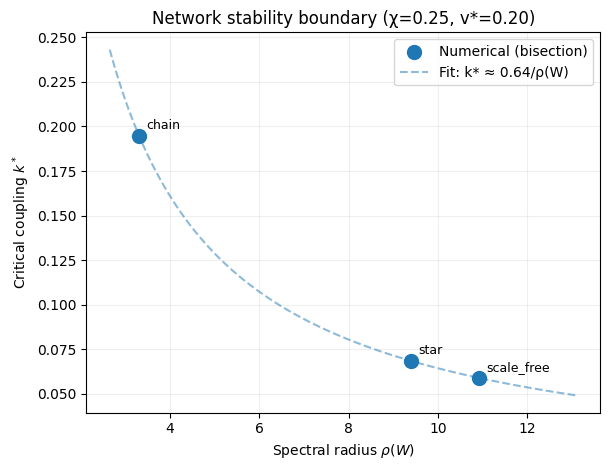

In [ ]:
fig, ax = plt.subplots(figsize=(6.2, 4.8))

# Extract data for plotting
names = list(results.keys())
rhos = [results[n]['rho'] for n in names]
k_stars = [results[n]['k_star_numerical'] for n in names]
k_hopfs = [results[n]['k_star_hopf'] if results[n]['k_star_hopf'] else np.nan for n in names]

# Plot numerical results
ax.scatter(rhos, k_stars, s=100, marker='o', label='Numerical (bisection)', zorder=3)

# Plot Hopf predictions (if available)
valid_hopf = [(r, k, n) for r, k, n in zip(rhos, k_hopfs, names) if not np.isnan(k)]
if valid_hopf:
    rhos_h, k_hopfs_h, names_h = zip(*valid_hopf)
    ax.scatter(rhos_h, k_hopfs_h, s=100, marker='x', c='red',
               label='Hopf prediction', zorder=3)

# Annotate points
for name, rho, k_star in zip(names, rhos, k_stars):
    ax.annotate(name, (rho, k_star), xytext=(5, 5),
                textcoords='offset points', fontsize=9)

# Add trend line (rough inverse relationship)
rho_smooth = np.linspace(min(rhos)*0.8, max(rhos)*1.2, 100)
# Rough fit: k* ∝ 1/ρ (from Hopf condition)
from scipy.optimize import curve_fit
def inverse_model(rho, a):
    return a / rho
popt, _ = curve_fit(inverse_model, rhos, k_stars)
ax.plot(rho_smooth, inverse_model(rho_smooth, *popt), '--',
        alpha=0.5, label=f'Fit: k* ≈ {popt[0]:.2f}/ρ(W)')

ax.set_xlabel(r"Spectral radius $\rho(W)$")
ax.set_ylabel(r"Critical coupling $k^*$")
ax.set_title(rf"Network stability boundary (χ={chi_lin:.2f}, v*={lp.vstar:.2f})")
ax.legend(frameon=True)
ax.grid(alpha=0.2)

fig.tight_layout()
png_path = OUT_DIR / "network_stability_k_star_vs_rho.png"
fig.savefig(png_path, dpi=300)

print(f"✓ Saved: {png_path.name}")
png_path


## Interpretation

### Equilibrium existence $(Δ_op)$ vs Network stability (k*)

1. **Δ_op > 0**: Isolated node equilibrium exists for given (χ, I_max)
   - From discriminant of quadratic (κ=0 case)
   - Does NOT guarantee stability

2. **k* (critical coupling)**: Linearized network loses stability at k > k*
   - From Jacobian eigenanalysis
   - Depends on topology via ρ(W)
   - Generally: k* ∝ 1/ρ(W) for symmetric networks

3. **Design principle**: To ensure stable operation:
   - Choose (χ, I_max) such that Δ_op > 0 (existence)
   - AND ensure k < k* for your network topology (stability)

### Topology effects

- **Chain**: Low ρ(W), high k* → most stable structure
- **Star**: High ρ(W), low k* → central hub creates vulnerability
- **Scale-free**: Intermediate, depends on degree distribution

### Caveats

- These are **surrogate** analyses of the continuous (v,u) drift
- The full spiking system includes:
  - Threshold events (discrete)
  - Resets (can stabilize or destabilize)
  - Delays (require DDE analysis, not done here)
- Use these as **design guidelines**, validate with full simulations


## Notes for manuscript

- **Main text**: Show (χ, I_max) heatmap only
- **Online Methods**: Include 1D sweeps and network stability analysis
- **Supplementary**: Full topology comparison with simulation validation

**Key message**: Operational margin (Δ_op) is a necessary but not sufficient condition.
Network stability requires additional checks via linearization or simulation.
